In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nInst = 0
nt = 0

weekSpan = 7
fortnightSpan = 14
monthSpan = 30

# Commission rate
commRate = 0.0025 # was 0.0050

# Dollar position limit (maximum absolute dollar value of any individual stock position)
dlrPosLimit = 10000

timeOut=600 

pricesFile="./prices.txt"
df=pd.read_csv(pricesFile, sep='\s+', header=None, index_col=None)
nt, nInst = df.values.shape
prcAll = (df.values).T
df = pd.DataFrame(prcAll)
df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,40.44,40.58,40.52,40.47,40.23,40.22,40.28,40.18,40.30,40.28,...,43.64,43.75,43.70,43.80,43.69,43.80,43.87,43.66,43.61,43.52
1,4.90,4.88,4.90,4.92,4.91,4.95,4.95,4.92,4.92,4.91,...,4.12,4.13,4.13,4.14,4.13,4.13,4.13,4.14,4.14,4.12
2,30.92,30.95,31.02,30.98,30.93,30.89,30.86,30.78,30.71,30.68,...,28.59,28.61,28.59,28.55,28.56,28.54,28.56,28.59,28.64,28.68
3,18.51,18.41,18.37,18.42,18.39,18.42,18.31,18.37,18.41,18.36,...,17.77,17.75,17.93,18.00,18.01,17.95,17.96,18.05,18.06,18.06
4,47.69,47.55,47.70,47.66,48.09,47.97,48.07,47.95,48.05,48.16,...,47.62,47.84,47.70,47.97,47.57,47.41,47.11,47.13,46.72,47.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,63.15,63.15,63.16,63.19,63.19,63.16,63.16,63.13,63.10,63.07,...,61.66,61.68,61.69,61.69,61.68,61.66,61.67,61.67,61.69,61.71
96,51.62,51.69,51.68,51.74,51.81,51.84,51.91,51.82,51.83,51.72,...,50.27,50.35,50.31,50.32,50.25,50.22,50.26,50.29,50.32,50.30
97,11.12,11.15,11.16,11.14,11.14,11.11,11.06,11.06,11.02,11.01,...,9.82,9.82,9.82,9.81,9.80,9.81,9.81,9.82,9.81,9.79
98,33.32,33.35,33.31,33.70,33.76,33.74,33.81,33.69,33.46,33.67,...,33.54,33.60,33.50,33.58,33.69,33.94,34.06,33.86,34.06,34.17


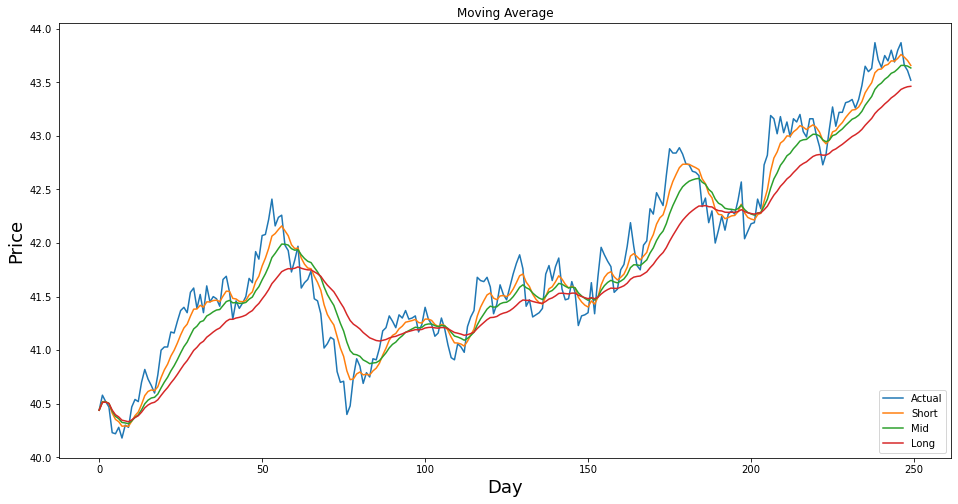

,Close,ShortEWMA,MidEWMA,LongEWMA
0,40.44,40.440000,40.440000,40.440000
1,40.58,40.520000,40.515000,40.512333
2,40.52,40.520000,40.516910,40.515061
3,40.47,40.501714,40.502559,40.502645
4,40.23,40.412650,40.431449,40.440612
...,...,...,...,...
245,43.80,43.723300,43.625179,43.403775
246,43.87,43.759975,43.657822,43.433854
247,43.66,43.734981,43.658113,43.448444
248,43.61,43.703736,43.651698,43.458867


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

prc_series = pd.DataFrame(prcAll[0], columns=['Close'])
prc_series['ShortEWMA'] = prc_series['Close'].ewm(span=weekSpan).mean()
prc_series['MidEWMA'] = prc_series['Close'].ewm(span=fortnightSpan).mean()
prc_series['LongEWMA'] = prc_series['Close'].ewm(span=monthSpan).mean()

  
# visualise
plt.figure(figsize=(16,8))
plt.title("Moving Average")
plt.plot(prc_series["Close"])
plt.plot(prc_series["ShortEWMA"])
plt.plot(prc_series["MidEWMA"])
plt.plot(prc_series["LongEWMA"])
plt.xlabel("Day", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.legend(["Actual","Short", "Mid", "Long"], loc = "lower right")
plt.show()

prc_series

In [27]:
# days looking back for moving avg
weekSpan = 7
fortnightSpan = 14
monthSpan = 30

nInst=100
currentPos = np.zeros(nInst)

def position3EMA (prcSoFar):
    global currentPos
    
    for i in range(len(prcSoFar)):
        close_prc = prcSoFar[i][-1]

        flag_short = False
        flag_long = False

        # calculate moving avg
        prc_series = pd.DataFrame(prcSoFar[i], columns=['Close'])
        prc_series['ShortEWMA'] = prc_series['Close'].ewm(span=weekSpan).mean()
        prc_series['MidEWMA'] = prc_series['Close'].ewm(span=fortnightSpan).mean()
        prc_series['LongEWMA'] = prc_series['Close'].ewm(span=monthSpan).mean()

        # setting trade criteria
        for j in range(0, len(prc_series)):
            if (prc_series['MidEWMA'][j] < prc_series['LongEWMA'][j]) and (prc_series['ShortEWMA'][j] < prc_series['MidEWMA'][j]) and flag_long == False:
                currentPos[i] -= round(5000 / close_prc)
                flag_short = True
            elif flag_short == True and (prc_series['ShortEWMA'][j] > prc_series['MidEWMA'][j]):
                currentPos[i] += round(5000 / close_prc)
                flag_short = False
            elif (prc_series['MidEWMA'][j] > prc_series['LongEWMA'][j]) and (prc_series['ShortEWMA'][j] > prc_series['MidEWMA'][j]) and flag_long == False:
                currentPos[i] -= round(5000 / close_prc)
                flag_long = True
            elif flag_long == True and (prc_series['ShortEWMA'][j] < prc_series['MidEWMA'][j]):
                currentPos[i] += round(5000 / close_prc)
                flag_long = False

    return currentPos

In [41]:
def calculateGradient(x1, y1, x2, y2):
    if (x2 - x1 != 0):
        m = (y2 - y1) / (x2 - x1)
    else:
        m = 0
    return m

def positionGradient(prcSoFar):
    global currentPos
    
    for i in range(len(prcSoFar)):
        close_prc = prcSoFar[i][-1]

        # days looking back for moving avg
        span = 15
        span_ceiling = 30
        span_floor = 10
        grad = 0
        
        # changing span depending on volatility
        if len(prcSoFar[0]) > 31:

            todayVola = np.std(prcSoFar[i][-31:-2])
            yesterdayVola = np.std(prcSoFar[i][-30:])

            normVola = (todayVola - yesterdayVola) / todayVola
            span = round(span * (1 + normVola))

            if span > span_ceiling:
                span = span_ceiling
            elif span < span_floor:
                span = span_floor


        # calculate moving avg
        prc_series = pd.DataFrame(prcSoFar[i], columns=['Close'])
        prc_series['EWMA'] = prc_series['Close'].ewm(span=span).mean()

        # setting boundaries for trade criteria
        avg_prc = sum(prcSoFar[i]) / len(prcSoFar[i])
        std_multiple = np.std(prcSoFar[i])
        shift = avg_prc*std_multiple

        # Calculate gradient for the period
        if (5 < len(prcSoFar[0]) and close_prc - prcSoFar[i][-(5+1)] != 0):
            grad = 5.0 / (close_prc - prcSoFar[i][-(5+1)])

        # setting trade criteria
        if (prc_series["EWMA"].iloc[-1] + shift  <= close_prc) and grad < 0:
            currentPos[i] -= round(8500 / close_prc)
        elif (prc_series["EWMA"].iloc[-1] - shift  >= close_prc) and grad > 0:
            currentPos[i] += round(8500 / close_prc)


    return currentPos


In [42]:
import time

nInst = 0
nt = 0

# Commission rate
commRate = 0.0025 # was 0.0050

# Dollar position limit (maximum absolute dollar value of any individual stock position)
dlrPosLimit = 10000

timeOut=600 

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    nt, nInst = df.values.shape
    return (df.values).T

pricesFile="./prc500.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

#currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global tStart
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    frac0 = 0.
    frac1 = 0.
    value = 0
    todayPLL = []
    (_,nt) = prcHist.shape
    tNow = time.time()
    for t in range(1,nt+1): #range(1,nt+1): 
        prcHistSoFar = prcHist[:,:t]
        # no trades on the very last price update, only before the last update
        newPosOrig = curPos
        tNow = time.time()
        tRunning = tNow - tStart
        #print ("tRunning: %.4lf" % tRunning)
        if (t < nt) and (tRunning <= timeOut):
            newPosOrig = positionGradient(prcHistSoFar)
            # otherwise keep the same desired positions
        if (tRunning > timeOut):
            print ("TIME OUT [ %.3lf > %lf]!" % (tRunning, timeOut))
        curPrices = prcHistSoFar[:,-1] #prcHist[:,t-1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.array([int(p) for p in np.clip(newPosOrig, -posLimits, posLimits)])
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" % (t,value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = 16 * plmu / plstd
    return (plmu, ret, annSharpe, totDVolume)



tStart = time.time()
(meanpl, ret, sharpe, dvol) = calcPL(prcAll)
tEnd = time.time()
tRun = tEnd - tStart
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)
print ("runTime  : %.3lf " % tRun)

Loaded 100 instruments for 500 days
Day 1 value: -2496.58 todayPL: $-2496.58 $-traded: 998632 return: -0.00250
Day 2 value: -2926.18 todayPL: $-429.60 $-traded: 1002344 return: -0.00292
Day 3 value: -4020.96 todayPL: $-1094.78 $-traded: 1006076 return: -0.00400
Day 4 value: -3482.94 todayPL: $538.02 $-traded: 1010100 return: -0.00345
Day 5 value: -2400.87 todayPL: $1082.07 $-traded: 1013768 return: -0.00237
Day 6 value: -1380.00 todayPL: $1020.87 $-traded: 1017592 return: -0.00136
Day 7 value: -68.77 todayPL: $1311.23 $-traded: 1021541 return: -0.00007
Day 8 value: 1717.29 todayPL: $1786.06 $-traded: 1025693 return: 0.00167
Day 9 value: 2855.41 todayPL: $1138.12 $-traded: 1029041 return: 0.00277
Day 10 value: 3037.47 todayPL: $182.06 $-traded: 1033683 return: 0.00294
Day 11 value: 3743.75 todayPL: $706.27 $-traded: 1037866 return: 0.00361
Day 12 value: 4686.98 todayPL: $943.24 $-traded: 1041736 return: 0.00450
Day 13 value: 3878.28 todayPL: $-808.70 $-traded: 1045647 return: 0.00371
Da